In [5]:
import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import ESC3

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6610201500606657438
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11537383540886328718
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10397176983486019679
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1472462199567894549
physical_device_desc: "device: XLA_GPU device"
]


## Fold Training

In [2]:
fold_train_loss = []
fold_train_accuracy = []
fold_valid_loss = []
fold_valid_accuracy = []
fold_test = []

In [3]:
# Define training parameters
max_epochs = 50
lr = 0.0001
batch_size = 128

# Loop over the functions
for i in range(1, 6):
    
    print(f'\n###############################################################')
    print(f'######################## FOLD-{i} #############################')
    print(f'###############################################################')
    # load the fold data
    train_d, train_l, val_d, val_l, test_d, test_l = ESC2.Load_Segments('ESC10', i)
    
    # Generate training and validation dataset
    training_dataset = ESC2.CreateTrainingSet(train_d, train_l, name=f'train_F{i}', batch_size=batch_size)
    validation_dataset = ESC2.CreateValidationSet(val_d, val_l, name=f'valid_F{i}', batch_size=batch_size)
    
    # Initialize the network
    net = ESC2.PiczakNet10([60, 41, 2])
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    opt = tf.keras.optimizers.Adam(lr=lr)
    net.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])
    
    # Train the network
    epoch_loss, epoch_acc, epoch_vl, epoch_va = ESC2.train(net, max_epochs, training_dataset, validation_dataset, verbose=True)
    
    # Append lossed for confidence plot
    fold_train_loss.append(epoch_loss)
    fold_train_accuracy.append(epoch_acc)
    fold_valid_loss.append(epoch_vl)
    fold_valid_accuracy.append(epoch_va)
    

Epoch  1: 	 t-loss: 2.277082 	 t-acc: 0.107449 	 v-loss: 2.199326 	 v-acc: 0.210337 	 time: 58.000
Epoch  2: 	 t-loss: 2.170640 	 t-acc: 0.177228 	 v-loss: 2.008027 	 v-acc: 0.215824 	 time: 55.653
Epoch  3: 	 t-loss: 2.020073 	 t-acc: 0.221397 	 v-loss: 1.778791 	 v-acc: 0.331888 	 time: 56.488
Epoch  4: 	 t-loss: 2.012236 	 t-acc: 0.210444 	 v-loss: 1.812718 	 v-acc: 0.329405 	 time: 57.198
Epoch  5: 	 t-loss: 1.972242 	 t-acc: 0.231539 	 v-loss: 1.799627 	 v-acc: 0.317125 	 time: 55.423
Epoch  6: 	 t-loss: 1.930916 	 t-acc: 0.247976 	 v-loss: 1.733393 	 v-acc: 0.397654 	 time: 58.715
Epoch  7: 	 t-loss: 1.914093 	 t-acc: 0.249454 	 v-loss: 1.834320 	 v-acc: 0.320992 	 time: 57.792
Epoch  8: 	 t-loss: 1.906216 	 t-acc: 0.271030 	 v-loss: 1.715786 	 v-acc: 0.360995 	 time: 55.918
Epoch  9: 	 t-loss: 1.868352 	 t-acc: 0.281325 	 v-loss: 1.667170 	 v-acc: 0.387019 	 time: 55.856
Epoch 10: 	 t-loss: 1.858788 	 t-acc: 0.278177 	 v-loss: 1.520101 	 v-acc: 0.541884 	 time: 57.142
Epoch 11: 

In [6]:
# Convert lists to array
fold_train_loss = np.asarray(fold_train_loss)
fold_train_accuracy = np.asarray(fold_train_accuracy)
fold_valid_loss = np.asarray(fold_valid_loss)
fold_valid_accuracy = np.asarray(fold_valid_accuracy)

# Compute mean and confidence interval
m_tl = []
m_ta = []
m_vl = []
m_va = []

ci_tl = []
ci_ta = []
ci_vl = []
ci_va = []

for i in range(max_epochs):
    m_tl.append(np.mean(fold_train_loss[:, i]))
    m_ta.append(np.mean(fold_train_accuracy[:, i]))
    m_vl.append(np.mean(fold_valid_loss[:, i]))
    m_va.append(np.mean(fold_valid_accuracy[:, i]))
    
    ci_tl.append(1.96*np.std(fold_train_loss[:, i])/np.mean(fold_train_loss[:, i]))
    ci_ta.append(1.96*np.std(fold_train_accuracy[:, i])/np.mean(fold_train_accuracy[:, i]))
    ci_vl.append(1.96*np.std(fold_valid_loss[:, i])/np.mean(fold_valid_loss[:, i]))
    ci_va.append(1.96*np.std(fold_valid_accuracy[:, i])/np.mean(fold_valid_accuracy[:, i]))

m_tl = np.asarray(m_tl)
m_ta = np.asarray(m_ta)
m_vl = np.asarray(m_vl)
m_va = np.asarray(m_va)

ci_tl = np.asarray(ci_tl)
ci_ta = np.asarray(ci_ta)
ci_vl = np.asarray(ci_vl)
ci_va = np.asarray(ci_va)

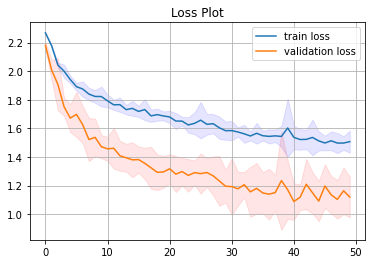

In [8]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(m_tl, label='train loss')
ax.fill_between(np.arange(0, max_epochs), (m_tl-ci_tl), (m_tl+ci_tl), color='b', alpha=.1)
ax.plot(m_vl, label='validation loss')
ax.fill_between(np.arange(0, max_epochs), (m_vl-ci_vl), (m_vl+ci_vl), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.title('Loss Plot')
plt.show()

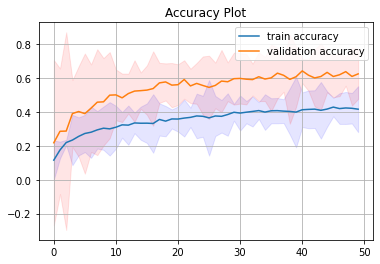

In [9]:
# Plot accuracy
fig, ax = plt.subplots()
ax.plot(m_ta, label='train accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_ta-ci_ta), (m_ta+ci_ta), color='b', alpha=.1)
ax.plot(m_va, label='validation accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_va-ci_va), (m_va+ci_va), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.title('Accuracy Plot')
plt.show()

In [4]:
# Find the best point before overfit on each run

# Retrain the network until that point

# Evaluate on the test set